In [1]:
%matplotlib inline


In [1]:
import concurrent
import concurrent.futures
import pickle
import re
import statistics
import warnings

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex
import tqdm
from itables import init_notebook_mode, show
from keras import models
from keras.layers import Dense, Input, Reshape
from keras.models import Model
from sklearn.cluster import (AffinityPropagation, AgglomerativeClustering,
                             KMeans)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score,
                             auc, classification_report, davies_bouldin_score,
                             roc_auc_score, roc_curve, silhouette_score,
                             v_measure_score)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import (LabelEncoder, QuantileTransformer,
                                   label_binarize, normalize)

from featgenerator.config import Config
from featgenerator.exif_feat import ExifFeatures
from featgenerator.featurizer import Featurizer
from featgenerator.floss_general_feat import FlossFeatures
from featgenerator.floss_regex import FlossRegexFeatures
from featgenerator.lief_features import (LiefFeatures,
                                         get_features_from_function_lists)
from featgenerator.malcat import MalcatFeatures
from featgenerator.util import ClusteringMetrics, MinHashLSHForest


In [2]:
from featgenerator import doc_features
from featgenerator.util import ClusteringMetrics

In [3]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [4]:
from importlib import reload
from featgenerator import util

util = reload(util)



####Before loading config make sure you have the right root_dir in the config file

In [5]:
conf = Config()
adversary_dataset = pd.read_csv(conf.get_adversary_mapping())
adversary_dataset['hash'] = adversary_dataset['sha256'].copy()

In [6]:
floss_feat = FlossFeatures()
#fdf = floss_feat.get_features()
#fdf['hash'] = fdf['hash'].astype(str)

# exif_feautres = ExifFeatures()
# exf = exif_feautres.get_normalized_features()
# exf['hash'] = exf['hash'].astype(str)

malcat_feat = MalcatFeatures()
mcf = malcat_feat.get_features()
mcf['hash'] = mcf['hash'].astype(str)

# flossregex_feat = FlossRegexFeatures()
# reg = flossregex_feat.get_features()


In [7]:
# exf.shape, mcf.shape

In [8]:
doc_features = reload(doc_features)

In [9]:
%%time
doc_feat = doc_features.DocFeatures()
dcf = doc_feat.get_features()
dcf['hash'] = dcf['hash'].astype(str)

CPU times: total: 31.2 ms
Wall time: 67.2 ms


In [10]:
raw_strings_dataset = floss_feat.get_dataset(floss_feat.root_dir, floss_feat.floss_filename)

In [11]:
raw_string_df = pd.DataFrame(raw_strings_dataset)[['hash', 'strings']]
raw_string_df = raw_string_df[raw_string_df['hash'].isin(dcf.hash)]

In [12]:
%%time
string_processor = util.StringProcessing()

raw_string_df['filtered_strings'] = raw_string_df['strings'].apply(lambda x: " , ".join(string_processor.process_strings(list(x))))
filtered_strings_list = raw_string_df['filtered_strings'].tolist()
vectorizer = CountVectorizer(analyzer='char', stop_words = 'english', ngram_range=(1, 3), max_features=1000000)
character_matrix = vectorizer.fit_transform(filtered_strings_list)
normalized_matrix = normalize(character_matrix)
embedding_df = pd.DataFrame(normalized_matrix.toarray(), columns=vectorizer.get_feature_names_out())


CPU times: total: 7.39 s
Wall time: 18 s


In [13]:
embedding_df['hash'] = dcf['hash'].astype(str).copy()
#embedding_df.to_pickle("datasets/document_embedding_df.pkl")

In [14]:
#embedding_df = pd.read_pickle("datasets/document_embedding_df.pkl")

In [15]:
mcf.shape, dcf.shape, embedding_df.shape

((218, 58), (58, 59), (58, 43947))

In [16]:
joined_inner = dcf
# joined_inner = dcf.merge(exf,how="inner", on=["hash"])
joined_inner = joined_inner.merge(mcf, how="inner", on=["hash"])


In [17]:
 ###This block is when we want to add embedded strings in the autoencoder pipeline

#embedding_df['hash'] = dcf['hash'].astype(str).copy()
#joined_inner = joined_inner.merge(embedding_df,how="inner", on=["hash"])

In [18]:
##Run this block when we want to separate the embeddded strings from autoencoder pipeline

embedding_df = embedding_df.copy().drop(columns=['hash'])

In [19]:
joined_inner.shape

(58, 116)

In [20]:
# ## This block is for whole dataset with Normalised group tags

# all_features = joined_inner.merge(adversary_dataset[['hash','Report link', 'Normalized_Tag', 'Campaign_Tag']], left_on="hash",right_on="hash")
# feat = all_features.copy().drop(columns=['hash'])
# X = feat.drop(columns=["Normalized_Tag", "Report link"])
# y = feat['Normalized_Tag'].fillna('-1')

In [21]:
##This block is for Reference dataset with Campaign Tags

all_features = joined_inner.merge(adversary_dataset[['hash','Campaign_Tag',  'Normalized_Tag', 'Report link']], left_on="hash",right_on="hash")
feat = all_features.copy().drop(columns=['hash'])
X = feat.drop(columns=["Campaign_Tag", "Report link" ,  'Normalized_Tag'])
y = feat['Campaign_Tag'].fillna('-1')

In [22]:
# feat['Campaign_Tag']A

In [23]:
X = np.asarray(X).astype(np.float32)


In [24]:
def silhouette_scorer(estimator, X):
    y_pred = estimator.fit_predict(X)
    return silhouette_score(X, y_pred)

In [25]:
from keras.optimizers import Adam

In [26]:
# Define the hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 10

# Create the model
input_layer = Input(shape=(X.shape[1],))
hidden_layer1 = Dense(32, activation='relu')(input_layer)
hidden_layer2 = Dense(16, activation='relu')(hidden_layer1)
output_layer = Dense(X.shape[1], activation='sigmoid')(hidden_layer2)
autoencoder = Model(input_layer, output_layer)

# Compile the model
autoencoder.compile(loss='mean_squared_error', optimizer=Adam(learning_rate))

# Train the model
autoencoder.fit(X, X, batch_size=batch_size, epochs=num_epochs)
X_encoded = autoencoder.predict(X)


Epoch 1/10
2/2 [==============================] - 0s 7ms/step - loss: 0.2484
Epoch 2/10
2/2 [==============================] - 0s 0s/step - loss: 0.2471
Epoch 3/10
2/2 [==============================] - 0s 0s/step - loss: 0.2457
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.2443
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.2427
Epoch 6/10
2/2 [==============================] - 0s 0s/step - loss: 0.2410
Epoch 7/10
2/2 [==============================] - 0s 17ms/step - loss: 0.2392
Epoch 8/10
2/2 [==============================] - 0s 0s/step - loss: 0.2372
Epoch 9/10
2/2 [==============================] - 0s 0s/step - loss: 0.2349
Epoch 10/10
2/2 [==============================] - 0s 0s/step


In [27]:
X_encoded.shape

(58, 115)

In [28]:
# combined_features = X_encoded.copy()
# combined_features = X.copy()
combined_features = np.hstack([embedding_df.to_numpy(), X_encoded])
n_clusters = np.arange(2, 35, 2)
n_clusters = list(n_clusters)

In [29]:
#agglomerative = AgglomerativeClustering(n_clusters=22, metric="euclidean", linkage="ward")
#y_pred = agglomerative.fit_predict(combined_features)

In [30]:
combined_features.shape

(58, 44061)

In [31]:
# best_param, best_truth_matrix['majority_vote'].nunique(), best_truth_matrix['Campaign_Tag'].nunique()

In [32]:
util = reload(util)

In [55]:
# modelling = util.Modelling()
# all_params, best_param, best_truth_matrix = modelling.find_best_agglo(combined_features, n_clusters, all_features[['hash', 'Campaign_Tag']], 'Campaign_Tag')

agglomerative = AgglomerativeClustering(n_clusters=32, metric="euclidean", linkage="ward")
y_pred = agglomerative.fit_predict(combined_features)
merged_adversary_experiment_final = all_features.copy()
merged_adversary_experiment_final['labels'] = y_pred
clustering_metrics = util.ClusteringMetrics()
truth_matrix, precision, recall = clustering_metrics.metrics_using_labels(merged_adversary_experiment_final, evaluation_column = 'Campaign_Tag')
truth_matrix.fillna('0', inplace=True)
evaluation_column = 'Campaign_Tag'
sk_precision = classification_report(truth_matrix[evaluation_column], truth_matrix.majority_vote, output_dict=True, zero_division=True).get("weighted avg", {}).get("precision", 0)
# sk_recall = classification_report(truth_matrix[evaluation_column], truth_matrix.majority_vote, output_dict=True, zero_division=True).get("weighted avg", {}).get("recall", 0)
# # sk_f1_score = classification_report(truth_matrix[evaluation_column], truth_matrix.majority_vote, output_dict=True, zero

In [ ]:
non_hashes = [
    '84523ddad722e205e2d52eedfb682026928b63f919a7bf1ce6f1ad4180d0f507',
    'd0d626deb3f9484e649294a8dfa814c5568f846d5aa02d4cdad5d041a29d5600',
    '0250b273344317c9a1e5a49fb7e0d2d8d2e3e3a6c6fccf1039d52122df9747ba',
]

In [60]:
truth_matrix

hash  labels  \
0   0250b273344317c9a1e5a49fb7e0d2d8d2e3e3a6c6fccf...      28   
1   a949ec428116489f5e77cefc67fea475017e0f50d2289e...      28   
2   c97acea1a6ef59d58a498f1e1f0e0648d6979c4325de3e...      28   
3   0b224045dffedaf345b1f72a19d9665b49e677cbacf3f8...      11   
4   64df5672d2d04064b6b25da42c73f4509874b914d3e7f9...      11   
5   0bbe40e99636478e07fc2c8cc73262348009072c3286e2...      14   
6   27679b5a935882d53a50630b65c438252da32a645879f7...      14   
7   4c2091325eedc12f25e3b4b98af681ca0e4ea5abcb461c...      14   
8   93b2e45c13ba5c785dfd9e21ad2f6fe7289470e8504a89...      14   
9   bdb460527ac7ef739a013083d2268381a1464b845a05b3...      14   
10  0d4352322160339f87be70c2f3fe096500cfcdc95a8dea...       1   
11  42a782d342fb70169b07a5c2be054af49f88ffa92d0424...       1   
12  4588f52af10e123b050539fe48c317056e944b3ff0f9db...       1   
13  86981680172bbf0865e7693fe5a2bbe9b3ba12b3f1a153...       1   
14  d4be329aa00c2610a4ab48e7924cd77212de1648392ae3...       1   
15  11dbbad391345d5817cad17a5c7e4db5b75f005a045006...       5   
16  da7d584d69e037a5b3cf3ef90fd5304bbaac72c0d78a99...       5   
17  1b0c82e71a53300c969da61b085c8ce623202722cf3fa2...      29   
18  2046bb14d9f63612a6d19d5224727f3607be4e8f8ad13e...       2   
19  59e1edf4d82fae4978e97512b0331b7eb21dd4b838b850...       2   
20  aa124a4b4df12b34e74ee7f6c683b2ebec4ce9a8edcf9b...       2   
21  28cd09ecad4149eec8665edf79c1c2036df67375f964e7...       8   
22  a81645ee53f986c8a6a1dadeb4a7ad4f74aa8f4e553655...       8   
23  28d8b150f499e0cd83f293c1f2f2bfc9248c94aa9115f2...      31   
24  322aa22163954ff3ff017014e357b756942a2a762f1c55...      18   
25  356e41492d437e4bb2c98796dd8944d7e4c79a347376e6...      26   
26  40fbac7a241bea412734134394ca81c0090698cf0689f2...      20   
27  42f640fc14bda79c0507e6b939e0c0eee013375b972764...       0   
28  609dde6988a84f7f69719455b2faa7d33ba95c32cbc8bf...       0   
29  84523ddad722e205e2d52eedfb682026928b63f919a7bf...       0   
30  d0d626deb3f9484e649294a8dfa814c5568f846d5aa02d...       0   
31  fc95b67fa0664bf2d542f07120a3b51d47ff8eb55a94d0...       0   
32  43b6b0af744124da5147aba81a98bc7188718d5d205acf...      15   
33  44365e0bcd77f1721d061dc03dd3c1728ad36671ad294e...      23   
34  49724ee7a6baf421ac5a2a3c93d32e796e2a33d7d75bbf...      13   
35  d1e2a9367338d185ef477acc4d91ad45f5e6a7d11936c3...      13   
36  4a08c391f91cc72de7a78b5fd5e7f74adfecd77075e191...      16   
37  4dcad5842255051edd5c39212092569c906ad420ab1fc2...      25   
38  66e5371c3da7dc9a80fb4c0fabfa23a30d82650c434eec...       6   
39  d7ef8935437d61c975feb2bd826d018373df099047c33a...       6   
40  6a3446b8a47f0ab4f536015218b22653fff8b18c595fbc...      21   
41  6d726ae18ac70927a0424b7b3761bfb6241828a92b0efd...       4   
42  8e6fb36ef98a33ad35f0d3a15f602bb4263441722725cd...       4   
43  f5747bb30b6aeadee8163654a058c8fd085c0d6d60ad6a...       4   
44  f7fa22f3710cd7906a268081b51e34784be3798ed94dce...       4   
45  70f66e3131cfbda4d2b82ce9325fed79e1b3c7186bdbb5...      22   
46  7933716892e0d6053057f5f2df0ccadf5b06dc739fea79...      24   
47  803ecfae523b8e9f076265dabb39192f22aaa9a8e07576...      30   
48  8266d173465f4dfdaa0bce18cfea65859d174f1f2dac07...      19   
49  8510b40c23826fb3ee9cbc0a7b58b5176338020e6524bf...      10   
50  f4ac4d7bbd9998071b17ef30d3cb7e4126db06cdcc0c4b...      10   
51  85c1790c568176a2d3466fb00d8a49d4f70895eba80c86...       3   
52  db7e38f4d2606c7f456c1f043ddeefff17846576c82f23...       3   
53  8de4eb52db0ce19d295dd7f1c6e89522d1a09fa26709c0...       9   
54  a3eca35d14b0e020444186a5faaba5997994a47af08580...       7   
55  da72f270c60e07101368dfa087ad675ccaf0d5f167cc5c...      17   
56  df5536c254a5d9ac626dbff7525de8301729807433d377...      12   
57  ecbe46ca324096fd5e35729f39fa3bda9226bbefd6286d...      27   

           Campaign_Tag        majority_vote  TP  FP  
0                 C0022  StarBlizzardJan2024   0   1  
1   StarBlizzardJan2024  StarBlizzardJan2024   1   0  
2   StarBlizzardJan2024  StarBlizzardJan2024   1

In [78]:
all_features[all_features['hash'] == '2046bb14d9f63612a6d19d5224727f3607be4e8f8ad13e9efe34620fda2d9d99'].T

17
Keywords-Shell                                                         1
Keywords-Write                                                         0
Keywords-ADODB.Stream                                                  0
Keywords-{>N!                                                          0
Keywords-:(                                                            0
...                                                                  ...
BrowserStealer                                                         0
Zlib                                                                   0
Campaign_Tag                                                       C0006
Normalized_Tag                                       KoreanSpeakingActor
Report link            https://www.mcafee.com/blogs/other-blogs/mcafe...

[119 rows x 1 columns]

In [75]:
truth_matrix[truth_matrix['Campaign_Tag'] == 'C0006']

hash  labels Campaign_Tag  \
10  0d4352322160339f87be70c2f3fe096500cfcdc95a8dea...       1        C0006   
11  42a782d342fb70169b07a5c2be054af49f88ffa92d0424...       1        C0006   
12  4588f52af10e123b050539fe48c317056e944b3ff0f9db...       1        C0006   
13  86981680172bbf0865e7693fe5a2bbe9b3ba12b3f1a153...       1        C0006   
14  d4be329aa00c2610a4ab48e7924cd77212de1648392ae3...       1        C0006   
18  2046bb14d9f63612a6d19d5224727f3607be4e8f8ad13e...       2        C0006   

   majority_vote  TP  FP  
10         C0006   1   0  
11         C0006   1   0  
12         C0006   1   0  
13         C0006   1   0  
14         C0006   1   0  
18           3CX   0   1

In [57]:
all_features[all_features['Campaign_Tag'] == 'StarBlizzardJan2024']

Keywords-Shell  Keywords-Write  Keywords-ADODB.Stream  Keywords-{>N!  \
32               0               0                      0              0   
41               0               0                      0              0   
44               0               0                      0              0   

    Keywords-:(  Keywords-*;k  Keywords-Binary  Keywords-Base64Strings  \
32            0             0                0                       0   
41            0             0                0                       0   
44            0             0                0                       0   

    Keywords-Open  Keywords-<  ...  OpenSSL  MSVC_2013_rich  MinGW  \
32              0           0  ...        0               0      0   
41              0           0  ...        0               0      0   
44              0           0  ...        0               0      0   

    BruteforcePassword  KeyloggerApi  BrowserStealer  Zlib  \
32                   0             0               0     0   
41                   0             0               0     0   
44                   0             0               0     0   

           Campaign_Tag  Normalized_Tag  \
32  StarBlizzardJan2024    StarBlizzard   
41  StarBlizzardJan2024    StarBlizzard   
44  StarBlizzardJan2024    StarBlizzard   

                                          Report link  
32  https://blog.google/threat-analysis-group/goog...  
41  https://blog.google/threat-analysis-group/goog...  
44  Russian threat group COLDRIVER expands its tar...  

[3 rows x 119 columns]

In [48]:
# show(pd.DataFrame(all_params))

In [35]:
# %%time
# ##This block is for the whole dataset and scoring is done on SSE
# #combined_features = X.copy()
# combined_features = X_encoded.copy()
# #combined_features = np.hstack([embedding_df.to_numpy(), X_encoded])
# best_score = 0
# best_n = -1
# idx_res = {}
# for n_cluster in range(100, 200, 10):
#     agglomerative = AgglomerativeClustering(n_clusters=n_cluster, metric="euclidean", linkage="ward")
#     y_pred = agglomerative.fit_predict(combined_features)
#     cluster_centers = np.zeros((n_cluster, combined_features.shape[1]))
#     for cluster_label in np.unique(y_pred):
#         cluster_centers[cluster_label] = np.mean(combined_features[y_pred == cluster_label], axis=0)
#     distances = np.sum((combined_features - cluster_centers[y_pred])**2, axis=1)
#     sse_score = np.sum(distances)
#     if sse_score < best_score:
#         best_score = sse_score
#         best_n = len(set(y_pred))
#     idx_res[n_cluster] = sse_score


In [38]:
merg_res = all_features.copy()
merg_res['labels'] = y_pred


In [39]:
merg_res

Keywords-Shell  Keywords-Write  Keywords-ADODB.Stream  Keywords-{>N!  \
0                0               0                      0              0   
1                0               0                      0              0   
2                0               0                      0              0   
3                1               0                      0              0   
4                0               0                      0              0   
5                0               1                      1              0   
6                1               0                      0              0   
7                0               0                      0              0   
8                0               0                      0              0   
9                0               0                      0              0   
10               0               0                      0              0   
11               0               1                      1              0   
12               0               1                      1              0   
13               1               0                      0              0   
14               0               0                      0              0   
15               0               0                      0              0   
16               0               0                      0              0   
17               1               0                      0              0   
18               0               0                      0              0   
19               0               0                      0              0   
20               0               0                      0              0   
21               0               0                      0              0   
22               0               0                      0              0   
23               0               0                      0              0   
24               0               0                      0              0   
25               0               1                      1              0   
26               0               0                      0              0   
27               0               1                      1              0   
28               0               1                      1              1   
29               0               0                      0              0   
30               0               0                      0              0   
31               0               0                      0              0   
32               0               0                      0              0   
33               0               0                      0              0   
34               0               0                      0              0   
35               1               0                      0              0   
36               0               0                      0              0   
37               0               1                      1              0   
38               0               0                      0              0   
39               0               0                      0              0   
40               0               0                      0              0   
41               0               0                      0              0   
42               0               0                      0              0   
43               0               0                      0              0   
44               0               0                      0              0   
45               0               0                      0              0   
46               0               0                      0              0   
47               1               0                      0              0   
48               0               1                      1              0   
49               0               0                      0              0   
50               0               0                      0              0   
51               0               0                  

In [35]:
merg_res[(merg_res['hash'].isin(
[
# '51b47cd3fc139e20c21897a00ac4e3b096380f939633233116514a1f2d9e63d5', 
# '7a3b27cf04b7f8110fc1eee5f9c4830d38ac00467fc856330115af4bffaf35b6', 
# 'ca66b671a75bbee69a4a4d3000b45d5dc7d3891c7ee5891272ccb2c5aed5746c', 
# 'd37347f47bb8c7831ae9bb902ed27a6ce85ddd9ba6dd1e963542fd63047b829c'
    
    
# '4cd86e8acd3106495ac61be242936bc6fcb55fee3fba9e2d5c93242dc6c7d86a', 
#     'ebca565e21a42300e19f250f84b927fa3b32debf3fe13003a4aa5b71ed5cbee9', 
#     '39a3f26ff7a02c43327f457916220d542c91cd9726a3d0e7610b89c0bc96f038', 
#     '59e01e645b398bec49b8283e08a89d58398311dd58800659689c8c83a779ab21', 
#     '6bc8770206c5f2bb4079f7583615adeb4076f2e2d0c655fbafedd9669dc3a213', 
#     'a1e95ac1bb684186e9fb5c67f75c7c26ddc8b18ebfdaf061742ddf1675e17d55'
    
    
    #'54f5b2756715fcc4ddac9aeb8c637ed613cf37da813b99a0572916a6926446a2',
    #'cc8936507438fcf8757ff40309c6057aa780c394b158723b7e8fb07e09793344'
    
    'dbb9168502e819619e94d9dc211d5f4967d8083ac5f4f67742b926abb04e6676',
    '386ed7ba502e7bf0e60c546476c1c762cbc951eb2a2ba1f5b505be08d60310ef',
    '9ce56e1403469fc74c8ff61dde4e83ad72597c66ce07bbae12fa70183687b32d'
'5efde4441e4184c36a0dec9e7da4b87769a574b891862acdb4c3321d18cbca69',
'386ed7ba502e7bf0e60c546476c1c762cbc951eb2a2ba1f5b505be08d60310ef',
'dbb9168502e819619e94d9dc211d5f4967d8083ac5f4f67742b926abb04e6676',
'56349cf3188a36429c207d425dd92d8d57553b1f43648914b44965de2bd63dd6',
'a3c020bf50d39a58f5345b671c43d790cba0e2a3f631c5182437976adf970633',
'3bbae53fc00449166fd9255b3f3192deba0b81b41b6e173d454c398a857b5094' 
    
 
    
]
) )
][['hash','labels','Normalized_Tag']]

hash  labels  \
362   386ed7ba502e7bf0e60c546476c1c762cbc951eb2a2ba1...      57   
536   56349cf3188a36429c207d425dd92d8d57553b1f436489...      48   
1355  dbb9168502e819619e94d9dc211d5f4967d8083ac5f4f6...     168   

        Normalized_Tag  
362   TransparentTribe  
536              DoNot  
1355  TransparentTribe

In [37]:
merg_res[merg_res['labels']== 57][['hash','labels','Normalized_Tag','Campaign_Tag']]

hash  labels  \
21    0335de8eadbbd5dc7cbe92ef869bcea6f6596ac39a3868...      57   
188   1e8261104cbe4e09c19af7910f83e9545fd435483f24f6...      57   
258   295654e3284158bdb94b40d7fb98ede8f3eab72171e027...      57   
304   2f69f7df7a2ab7b1803bb50b23ac17f7047b4651513bdf...      57   
362   386ed7ba502e7bf0e60c546476c1c762cbc951eb2a2ba1...      57   
451   480be4b7c51e3277533087d03c9cadbbe213f40cf306ad...      57   
591   60170fbf11cd2d04b1eab4ce905ae8ca90ae0fe55cb563...      57   
610   64001be2fc9ccec320d48c75d2de8ad7cd74092065cb44...      57   
614   6604d806eb68fdf914dfb6bbf907a4f2bd9b8757fc4da4...      57   
738   7a8ef8f67bfb698ee7e3cfc0b891e4a35cac8be50f01cb...      57   
779   80afa62f99b864264fc2009ecf4b11779ab6bbfa71a70f...      57   
856   8cccdce85beca7b7dc805a7f048fcd1bc8f7614dd7e13c...      57   
1069  afba60125552729336ff567ec3f72571e84a823708e36e...      57   
1087  b29691ac40b8bbb12b13e84641ad20583d1387ca356850...      57   
1125  ba27ae12e6f3c2c87fd2478072dfa2747d368a507c69cd...      57   
1457  ef0a68eb3e2998acdd5fdce8acd980ea9077c44fefced8...      57   

        Normalized_Tag Campaign_Tag  
21    TransparentTribe          NaN  
188              APT28          NaN  
258          Gamaredon          NaN  
304         MuddyWater          NaN  
362   TransparentTribe          NaN  
451       WizardSpider          NaN  
591               FIN7          NaN  
610         MuddyWater          NaN  
614               FIN7          NaN  
738            Kimsuky          NaN  
779       WizardSpider          NaN  
856              APT28          NaN  
1069      WizardSpider          NaN  
1087  TransparentTribe          NaN  
1125         BlackTech          NaN  
1457              FIN7          NaN

In [34]:
merg_res[merg_res['Normalized_Tag']== 'Sidewinder'][['hash','labels','Normalized_Tag','Campaign_Tag']]

hash  labels  \
8     012db1429d38232415b021ef951091d0894703724c26f5...      58   
32    04e0d94b1a24d12d690c41a5142b8652cfb517454b0c52...      42   
59    08b9b5b7592004b8733544df1029e2fc085d82db1ba488...      78   
68    0ad6474d721b9bd93ca9720fa0e3a03d9278b3ebe46e08...      62   
79    0cc10dd6f4b3aa0848ae08b6ec32e2b3e7136e4f5fc776...     183   
85    0dd9d9638a59b6fbab792b7781962571b653c44ebae3d9...     183   
90    0e3c58b9349c2da25347613fe0946dd7a2f65d8ac3861b...      53   
94    0ee926f443c66a0d47365dbb6d21dcea6f6624e730c99f...      44   
120   121648be6641269d626d4d2ad79d234c99b121e0e05889...     121   
172   1ca25ffc4b20c3773777c5faea3e1505d55ff4fc601fa2...      44   
174   1cbec920afe2f978b8f84e0a4e6b757d400aeb96e8c0a2...     183   
200   1fd742baa9b2ab29e30780d9a92bc3e2db03d1a17f48f9...      69   
211   21646c896ccc422f64c7ed8888891d2946c4542260c6c0...     183   
215   22062b6bcda194e3734285fed6b2de341c694c52a8f60c...      80   
220   2309fd453e48241ed2305239750437df1317a256f40b00...      62   
243   280fb291d49f277067667838cdf30a940eaed9ed771244...      28   
264   2ab12f79e435abe40ad30076eb4722be724d766c8050dc...     124   
312   307665150f275e2346005a97eb621f6fc8f04ef95f9cd2...      62   
339   34446f7f60f730fcca145155d10d1aff0a1153b085836d...     183   
526   54efd37bcd2a78db67319dcbf12cda2647f586d72fd689...      53   
545   57c3c238dcf6662b0b6383007017e7708540c46adac835...     183   
557   5977e8169436ff69f57bba8e1094dab77545ecd10039d6...     183   
608   63aba37a9291a75256b9f89cb5a999ee6ada020be4917c...      67   
665   6e129c9d560074d7f5c782af618614b1ddc02f2916db9b...      26   
686   7238f4e5edbe0e5a2242d8780fb58c47e7d32bf2c4f860...     183   
776   8057829bd5f8fb2f40741c2fc32c46ad33ac21d144fef8...     183   
785   81f0bf821b910a2620669981c786fd348ed7694a830d84...     100   
813   863ddef1af72c82beae6456f407a88817c45c754fe86d0...     183   
822   87882b884afd4bd6d4da1fb5e3f87d728f128f75fae32a...      53   
830   892859ea9d86fc441b24222148db52eb33cd106c2ac68e...      83   
831   89899966ef870191df63c231098fe94f180520dc306a47...      62   
844   8b30570303dc26bc02fb95a42b4ce91ccf82a02998c67f...     183   
876   9001056791a03ec998f26805d462bc2ca336b2c3aeac2e...     183   
933   98af6635138045cae3f29995a587d0c8a7f14446a9d105...      98   
989   a324235c05e4c9351192e6b6ab252b0ca85434fddc8d88...     183   
1028  a89189f1c7c101c8d9c2637e571c4f8546df3ea557a576...       4   
1080  b1417d7ee62878ef75381e4a3a4f388ac08ac4d4bbd999...     100   
1115  b8a0ecbc61b2ad5700b8f4b920b6addb37e1d3b953915a...      28   
1295  d3122d94a7fde33bc1f35ab49f56408a19a46847cce368...     183   
1378  e0aae3c1a0d247bd2f582c4edf2e89310c4f1b247947d9...     183   
1386  e34158b6fd7c46d71c8a58993ba84cd884c4c6f68cab1c...     183   
1391  e40a12e6e64fdd06abe843b2e70bfc59c279923cec7bc4...       3   
1405  e713b77892c3c4e3b2ba006edf5f17904096369e2de17e...     183   
1438  ec558a2175deb1cb6c79a72a2b0b5a89f77b8a12a799f7...       8   
1465  f08ccc040c8d8db60f30a6d1026aa6523e97c6cf52b1b3...     183   
1473  f1cdd47f7a2502902d15adf3ac79c0f86348ba09f4a482...     183   
1510  fa0e06f5b0499360f1ed3da1fe6ed565363544f8ed4302...     183   

     Normalized_Tag Campaign_Tag  
8        Sidewinder          NaN  
32       Sidewinder          NaN  
59       Sidewinder          NaN  
68       Sidewinder          NaN  
79       Sidewinder          NaN  
85       Sidewinder          NaN  
90       Sidewinder          NaN  
94       Sidewinder          NaN  
120      Sidewinder          NaN  
172      Sidewinder          NaN  
174      Sidewinder          NaN  
200      Sidewinder          NaN  
211      Sidewinder          NaN  
215      Sidewinder          NaN  
220      Sidewinder          NaN  
243      Sidewinder          NaN  
264      Sidewinder          NaN  
312      Sidewinder          NaN  
339      Sidewinder          NaN  
526      Sidewinder          NaN  
545      Sidewinder          NaN  
557      Sidewinder          NaN  
608      Sidewinder          

In [73]:
from importlib import reload
util = reload(util)
viz_manager = util.Visualization()

In [65]:
viz_manager.best_truth_curve(best_truth_matrix,'Campaign_Tag', 'Campaign' )

NameError: name 'best_truth_matrix' is not defined

<module 'matplotlib.pyplot' from 'C:\\Users\\ricewater\\AppData\\Roaming\\Python\\Python310\\site-packages\\matplotlib\\pyplot.py'>

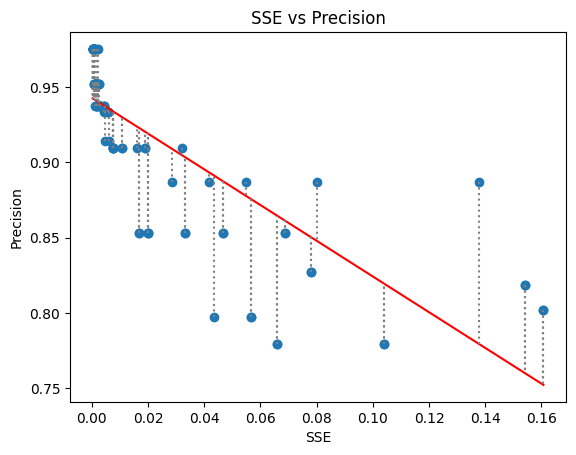

In [58]:
viz_manager = util.Visualization()
viz_manager.generate_precision_sse(all_params)

In [177]:
show(truth_matrix.merge(all_features[['hash','Campaign_Tag']], right_on='hash', left_on='hash'))

In [37]:
merg_res[(merg_res['hash'].isin(
['631c62e067667a02da63a97aeeb556bece8394deee59e62b48f63baecf4cf613',
 'c2dbaafccfb8c9121904629c1b643b99dfa934a2ec9f4bd8754ba3cad38b9a90',
 '7a3d7f1dc1e5d42e278785149a382651c70a8f967a153e1960cffff5f92eaa33',
 '6543180ba4e195b4f80399aae593eb7554588b61e651fce81b91fefa56baec30',
 '4ac3836414a384aee4c68e60eca54a848c8727a9e548de2b7ab76ecbd520107a',
 '9d0c2e8d0e2430c3e67b2677caff136e562570da162a371e9cfa6602c70b03bb',
 'c94d6649fe5c879ac2e4ccb313958736ac4c86f217c3a68c799f9641b6ac9f2a',
 'a1859ce1575ab08b6c3dc2731cef31e358dd3ccfc7d6febaccb6a730bc1d58c0',
 '179d18ad80b718d861ea0b4b06ad885e0a7760051497db6eb87315f92dd24b53',
 'b3c811595a0edbed9524a1a71ee9292c19792370c99f856f765a39f80a437418',
 'd12582262c06d6e0f68c62c891f469d819e18e0498fa2e9d277981f25eee93a1']
) )
][['hash','labels',"Campaign_Tag"]]

,hash,labels,Campaign_Tag


In [222]:
label_count = pd.DataFrame(merg_res['labels'].value_counts()).reset_index()
label_count.columns = ["labels","count"]

In [209]:
util = reload(util)

In [49]:
from itables import show

In [53]:
len(set(merg_res.labels))

25

In [62]:
show(merg_res[merg_res['labels']== 20][['hash','labels','Campaign_Tag','Report link']])

In [58]:
show(merg_res[merg_res['Campaign_Tag']== "C0007"][['hash','labels','Campaign_Tag', 'Report link']])

In [ ]:
merg_res[(merg_res['hash'].isin(
['631c62e067667a02da63a97aeeb556bece8394deee59e62b48f63baecf4cf613',
 'c2dbaafccfb8c9121904629c1b643b99dfa934a2ec9f4bd8754ba3cad38b9a90',
 '7a3d7f1dc1e5d42e278785149a382651c70a8f967a153e1960cffff5f92eaa33',
 '6543180ba4e195b4f80399aae593eb7554588b61e651fce81b91fefa56baec30',
 '4ac3836414a384aee4c68e60eca54a848c8727a9e548de2b7ab76ecbd520107a',
 '9d0c2e8d0e2430c3e67b2677caff136e562570da162a371e9cfa6602c70b03bb',
 'c94d6649fe5c879ac2e4ccb313958736ac4c86f217c3a68c799f9641b6ac9f2a',
 'a1859ce1575ab08b6c3dc2731cef31e358dd3ccfc7d6febaccb6a730bc1d58c0',
 '179d18ad80b718d861ea0b4b06ad885e0a7760051497db6eb87315f92dd24b53',
 'b3c811595a0edbed9524a1a71ee9292c19792370c99f856f765a39f80a437418',
 'd12582262c06d6e0f68c62c891f469d819e18e0498fa2e9d277981f25eee93a1']
) )
][['hash','labels',"Campaign_Tag"]]

In [65]:
clustering_metrics = util.ClusteringMetrics()
truth_matrix, precision, recall = clustering_metrics.metrics_using_labels(merged=merg_res[~merg_res.Campaign_Tag.isna()], evaluation_column='Campaign_Tag')
precision, recall

(0.8, 1.0)

In [ ]:
def get_reports(report_path="collection_from_vt.json"):
    collect_res = pd.read_json(report_path)
    collections_results = json.loads(collect_res.to_json(orient="records"))
    maps = []
    for k in collections_results:
        a = k.get("data")
        keys = k.get("links").get("self").split("/")[6]
        int_map = {"hash": keys, "reports": set()}
        for val in a:
            report = val.get("attributes").get("name")
            int_map["reports"].add(report)
        maps.append(int_map)
    return pd.DataFrame(maps)

In [ ]:
reports = get_reports()

In [ ]:
merg_res[(merg_res['labels']== 109) & (merg_res['Adversary']== 'Transparent Tribe')]

,exported_ServiceMain,exported_DllInstall,exported_DllRegisterServer,exported_DllUnregisterServer,exported_runtime.(*sigctxt...,exported_runtime.ready,exported_runtime.printslice,exported_io.MultiReader,exported_os.(*Process).wait,exported_net.getFields,...,248,249,250,251,252,253,254,255,Adversary,labels
476,0,0,0,0,0,0,0,0,0,0,...,0.034309,-0.007267,-0.079995,-0.023220,0.015178,0.012185,-0.005537,-0.010054,Transparent Tribe,109
662,0,0,0,0,0,0,0,0,0,0,...,-0.004148,0.009060,0.001612,-0.002161,0.001213,-0.011563,-0.011720,-0.008212,Transparent Tribe,109
1878,0,0,0,0,0,0,0,0,0,0,...,-0.003414,0.007124,0.004511,0.000026,0.000445,-0.009291,-0.010338,-0.008482,Transparent Tribe,109
2151,0,0,0,0,0,0,0,0,0,0,...,-0.055111,0.014645,0.014138,-0.027739,0.010511,0.002638,-0.064286,0.018234,Transparent Tribe,109
2164,0,0,0,0,0,0,0,0,0,0,...,-0.003940,0.006217,0.004379,-0.001321,-0.000576,-0.010681,-0.011455,-0.006318,Transparent Tribe,109
2208,0,0,0,0,0,0,0,0,0,0,...,0.035738,-0.008172,-0.079149,-0.021564,0.015153,0.014116,-0.004531,-0.009346,Transparent Tribe,109
2297,0,0,0,0,0,0,0,0,0,0,...,-0.004005,0.006471,0.003048,-0.002046,0.001416,-0.010477,-0.011975,-0.008497,Transparent Tribe,109
3199,0,0,0,0,0,0,0,0,0,0,...,0.034892,-0.007747,-0.079405,-0.021457,0.015033,0.014564,-0.004266,-0.009255,Transparent Tribe,109
3250,0,0,0,0,0,0,0,0,0,0,...,-0.020111,0.005884,-0.014274,-0.016417,0.007204,-0.004778,-0.008226,-0.014230,Transparent Tribe,109
3259,0,0,0,0,0,0,0,0,0,0,...,-0.003062,0.013347,0.001902,-0.005412,-0.005390,-0.008981,-0.010827,-0.014504,Transparent Tribe,109


In [ ]:
reports[reports['hash'].isin(merg_res[(merg_res['labels']== 109) & (merg_res['Adversary']== 'Transparent Tribe')].hash.tolist())]

hash  \
476   1eb0d373cea19124687ed4bffb0da3f80f98a18b9e0beb...   
662   2ac34da22b6ea2d1f2c3e41c9ce01d69b16abbad9d562a...   
1688  1eb0d373cea19124687ed4bffb0da3f80f98a18b9e0beb...   
1874  2ac34da22b6ea2d1f2c3e41c9ce01d69b16abbad9d562a...   
3090  81b67f89ebe7923e97582e3518272a49d94599107e147f...   
3363  93f2358f631d4bf5a1f16b40c5bb9479dbda492d6e96c2...   
3376  950532180701f8ac033a8796238d7e5b6900bc2652f28e...   
3420  979f7952dd2225c149f1766b4bca020b680364a77ddb60...   
3509  9ec58c011d7efbc2272a0403cd90cb4640858da7b08081...   
4411  dd47cf8ec70658af85e0cd23922462ac788305034fe78e...   
4462  e16df177681e356ab8a9491e841fa1a757bc40069e2f42...   
4471  e2200fa8b8c4757039e3f78536d9442817331f530e4348...   
4533  e63cd1c60fd8d9f2ab6714f371958621f9d500bb09ba35...   

                                                reports  
476   {Cymulate1, Transparent Tribe APT expands its ...  
662   {Transparent Tribe APT expands its Windows mal...  
1688  {Cymulate1, Transparent Tribe APT expands its ...  
1874  {Transparent Tribe APT expands its Windows mal...  
3090  {Transparent Tribe APT expands its Windows mal...  
3363  {Transparent Tribe APT expands its Windows mal...  
3376  {Transparent Tribe APT expands its Windows mal...  
3420  {Cymulate1, Transparent Tribe APT expands its ...  
3509  {Transparent Tribe APT expands its Windows mal...  
4411  {Transparent Tribe APT expands its Windows mal...  
4462  {Transparent Tribe APT Infrastructure Mapping,...  
4471  {Transparent Tribe APT expands its Windows mal...  
4533  {Transparent Tribe APT expands its Windows mal...

In [ ]:
merg_res = all_features.copy()
merg_res['labels'] = y_pred
merg_res[merg_res['hash'].isin(
[
'041a3c867a4d438be9783d88f99aa837da9d47487fe415c102f701c9918e1d7b',
'04385479e70d851e39822b8ce729a3402966c84ec03807a72a585d58d029a34a',
'b14abfbf5d149de8703357f959f4b2bd6e99125fd0641c840984bdc7f0d0b325',
'b1509b118d553d8d18c683c83eabdbce083a6d4206787d6a278b7eda5658f86b',
'b5a0917413007819da64d986367474cbb48e347521f416c0fbcc2889f18daef8',
'113c1c5e176cebe42e452e7ec6ded434c8f620372cef7ae7bfdc6b9469c1b3a4',
'7b2d13ca2d4d1909b2b63546c9e1b05b65b3cfdb88722e850a1d8bb5584a20b1',
'7b80bf96950c3be63e8ef035820e8b61ca73a11a33527f2cd904d110f4f5ef08',
'7b810ac05c0579071417d57d15865ba2966e4f9b6aa8f581938157158d6a8832',
'805263da772476ffac0486d10c1774dff7cbacbcf68e26e2b62d6c7534b10de8'
]
)
][['hash','labels', 'Adversary']]


,hash,labels,Adversary
75,041a3c867a4d438be9783d88f99aa837da9d47487fe415...,161,SideWinder
80,04385479e70d851e39822b8ce729a3402966c84ec03807...,161,SideWinder
268,113c1c5e176cebe42e452e7ec6ded434c8f620372cef7a...,50,SideWinder
1782,7b2d13ca2d4d1909b2b63546c9e1b05b65b3cfdb88722e...,161,SideWinder
1789,7b80bf96950c3be63e8ef035820e8b61ca73a11a33527f...,161,SideWinder
1790,7b810ac05c0579071417d57d15865ba2966e4f9b6aa8f5...,161,SideWinder
1851,805263da772476ffac0486d10c1774dff7cbacbcf68e26...,161,SideWinder
2584,b14abfbf5d149de8703357f959f4b2bd6e99125fd0641c...,161,SideWinder
2586,b1509b118d553d8d18c683c83eabdbce083a6d4206787d...,161,SideWinder
2640,b5a0917413007819da64d986367474cbb48e347521f416...,161,SideWinder


,hash,labels,Adversary
177,0b8e6a11adaa3df120ec15846bb966d674724b6b92eae3...,126,APT29
1924,84b846a42d94431520d3d2d14262f3d3a5d96762e56b0a...,372,APT29
2787,bec1981e422c1e01c14511d384a33c9bcc66456c1274bb...,372,APT29
3514,f3af394d9c3f68dff50b467340ca59a11a14a3d56361e6...,126,APT29
3655,fd3969d32398bbe3709e9da5f8326935dde664bbc36753...,187,APT29


In [ ]:
merg_res[merg_res['hash'].isin(
 [
'00654dd07721e7551641f90cba832e98c0acb030e2848e5efc0e1752c067ec07',
 '0322c4c2d511f73ab55bf3f43b1b0f152188d7146cc67ff497ad275d9dd1c20f',
 '03e9adae529155961f1f18212ff70181bde0e3da3d7f22961a6e2b1c9da2dd2e',
 '0b8e6a11adaa3df120ec15846bb966d674724b6b92eae34d63b665e0698e0193',
 '0c5ad1e8fe43583e279201cdb1046aea742bae59685e6da24e963a41df987494',
 '14e9b5e214572cb13ff87727d680633f5ee238259043357c94302654c546cad2',
 '2285a264ffab59ab5a1eb4e2b9bcab9baf26750b6c551ee3094af56a4442ac41',
 '4c8671411da91eb5967f408c2a6ff6baf25ff7c40c65ff45ee33b352a711bf9c',
 '58d8e65976b53b77645c248bfa18c3b87a6ecfb02f306fe6ba4944db96a5ede2',
 '5ca4a9f6553fea64ad2c724bf71d0fac2b372f9e7ce2200814c98aac647172fb',
 '65495d173e305625696051944a36a031ea94bb3a4f13034d8be740982bc4ab75',
 '7c39841ba409bce4c2c35437ecf043f22910984325c70b9530edf15d826147ee',
 '83014ab5b3f63b0253cdab6d715f5988ac9014570fa4ab2b267c7cf9ba237d18',
 '84b846a42d94431520d3d2d14262f3d3a5d96762e56b0ae471b853d1603ca403',
 '8749c1495af4fd73ccfc84b32f56f5e78549d81feefb0c1d1c3475a74345f6a8',
 '93e9383ae8ad2371d457fc4c1035157d887a84bbfe66fbbb3769c5637de59c75',
 '953b5fc9977e2d50f3f72c6ce85e89428937117830c0ed67d468e2d93aa7ec9a',
 'a4b790ddffb3d2e6691dcacae08fb0bfa1ae56b6c73d70688b097ffa831af064',
 'b75a5be703d9ba3721d046db80f62886e10009b455fa5cdfd73ce78f9f53ec5a',
 'bec1981e422c1e01c14511d384a33c9bcc66456c1274bbbac073da825a3f537d',
 'e329607379a01483fc914a47c0062d5a3a8d8d65f777fbad2c5a841a90a0af09',
 'e3d6057b4c2a7d8fa7250f0781ea6dab4a977551c13fe2f0a86f3519b2aaee7a',
 'f3af394d9c3f68dff50b467340ca59a11a14a3d56361e6cffd1cf2312a7028ad',
 'f622d031207d22c633ccec187a24c50980243cb4717d21fad6588dacbf9c29e9',
 'fd3969d32398bbe3709e9da5f8326935dde664bbc36753bd41a0b111712c0950'
 ]
)
][['hash','labels','Adversary']]

,hash,labels,Adversary
8,00654dd07721e7551641f90cba832e98c0acb030e2848e...,128,APT29
54,0322c4c2d511f73ab55bf3f43b1b0f152188d7146cc67f...,44,APT29
67,03e9adae529155961f1f18212ff70181bde0e3da3d7f22...,111,APT29
177,0b8e6a11adaa3df120ec15846bb966d674724b6b92eae3...,132,APT29
193,0c5ad1e8fe43583e279201cdb1046aea742bae59685e6d...,128,APT29
328,14e9b5e214572cb13ff87727d680633f5ee23825904335...,68,APT29
530,2285a264ffab59ab5a1eb4e2b9bcab9baf26750b6c551e...,78,APT29
1154,4c8671411da91eb5967f408c2a6ff6baf25ff7c40c65ff...,44,APT29
1318,58d8e65976b53b77645c248bfa18c3b87a6ecfb02f306f...,92,APT29
1371,5ca4a9f6553fea64ad2c724bf71d0fac2b372f9e7ce220...,128,APT29


In [ ]:
silhouette_score(X_encoded, y_pred)

0.34898248

## Important note on Silhuoette Co-efficient and Clustering Performance

It is possible that the model with the autoencoder and agglomerative clustering algorithm may have performed better in terms of clustering the data, even though it had a lower silhouette score. The silhouette score is a measure of the compactness and separation of the clusters, and it is calculated based on the mean intra-cluster distance and the mean nearest-cluster distance for each sample. However, it does not always capture the underlying structure of the data or the quality of the clusters.

## Visualization

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from keras.utils.vis_utils import plot_model


### TSNE Plot

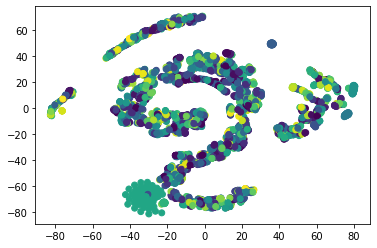

In [87]:
X_embedded = TSNE(n_components=2).fit_transform(X_encoded)

fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_pred, cmap='viridis')

cbar = plt.colorbar

### Plot Model Architecture

In [23]:
from keras.utils.vis_utils import plot_model


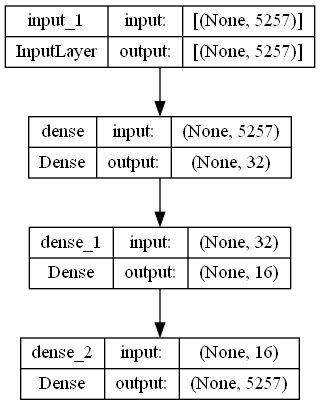

In [25]:
plot_model(autoencoder,show_shapes=True, show_layer_names=True)

In [45]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [78]:
merg_res = all_features.copy()
merg_res['labels'] = y_pred
merg_res[merg_res['hash'].isin(
[
'0424d436007274a5eee2fdca43d5f1f786db563fb94adc425d487ace708c1c6b',
  '3ce7dc7dfe8e58846f41797b24b1556175af46d14e06b93f29b7a68eed4c86e4',
  '3f254c62ad02f051ac2112f3aa92cb537f95d7de0d3c80ba5c42dc3a8a79090e',
  '4a4224f6c898ead010964627a9dcee369eb6205afc52a23253eb1eb7349b020a',
  '85b6c167b50c8d9807c80990ce88cc3bf7e4b449b7d86b347090b33d1bc0030b',
  'd3a402458682c4febacc6ae4bc98e15e92142603a97d51316eeee9e8bca77f88'
]
)
][['hash','labels','Adversary']]


,hash,labels,Adversary
77,0424d436007274a5eee2fdca43d5f1f786db563fb94adc...,0,Kimsuky
937,3ce7dc7dfe8e58846f41797b24b1556175af46d14e06b9...,194,Kimsuky
975,3f254c62ad02f051ac2112f3aa92cb537f95d7de0d3c80...,33,Kimsuky
1121,4a4224f6c898ead010964627a9dcee369eb6205afc52a2...,97,Kimsuky
1937,85b6c167b50c8d9807c80990ce88cc3bf7e4b449b7d86b...,84,Kimsuky
3088,d3a402458682c4febacc6ae4bc98e15e92142603a97d51...,97,Kimsuky


In [79]:
merg_res[merg_res['hash'].isin(
 ['1d13221e7778394e845d61f1ab71129134f6a7b50a83dad7d78ffece277714ee',
 '1d8579e2bba6c334f1ac6fcd9e54dca8ca098a756848b63d809209f0636b3a16',
 'ca9bcf268330a4fffcec025920514e0071651c35895b15b2f1dab8813c8b8e99',
 '9d6e14cd244f6c49e11d2b47f12116b5848aaed7a6aaa218fb023b33f7c12a3b',
 'bd5de5961f0efaa1473a822a86d53d2bfcedbfc6bd11cea65ff8e128b934a271',
 '08eaef6be41244bce8fdc908bee03ec7549197f4fcd7dd0da90a5c14f67e4c4b',
 '69adaf19cc19594e0193da88597b6af886f1c0e148ad980fa0fe3f9250d52332',
 '8ef94327cab01af04a83df86a662f3abe9ae35aa1084eff7273d8292941bebdb']
)
][['hash','labels', 'Adversary']]

,hash,labels,Adversary
138,08eaef6be41244bce8fdc908bee03ec7549197f4fcd7dd...,47,A41APT
457,1d13221e7778394e845d61f1ab71129134f6a7b50a83da...,54,APT10
461,1d8579e2bba6c334f1ac6fcd9e54dca8ca098a756848b6...,50,A41APT
1549,69adaf19cc19594e0193da88597b6af886f1c0e148ad98...,6,A41APT
2072,8ef94327cab01af04a83df86a662f3abe9ae35aa1084ef...,47,A41APT
2279,9d6e14cd244f6c49e11d2b47f12116b5848aaed7a6aaa2...,53,APT10
2967,ca9bcf268330a4fffcec025920514e0071651c35895b15...,53,APT10


### Model Scores

In [24]:
sse,db,slc = {}, {}, {}
for k in tqdm.tqdm(range(50, 2000,100)):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=10).fit(X_encoded)
    if k == 3: labels = kmeans.labels_
    clusters = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    db[k] = davies_bouldin_score(X_encoded,clusters)
    slc[k] = silhouette_score(X_encoded,clusters)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [3:26:43<00:00, 620.19s/it]


In [27]:
exec_values = {"sse": sse, "db": db, "slc": slc}

In [31]:
# pickle.dump(exec_values, open("featgenerator/scores/exec_scores.pkl","wb"))

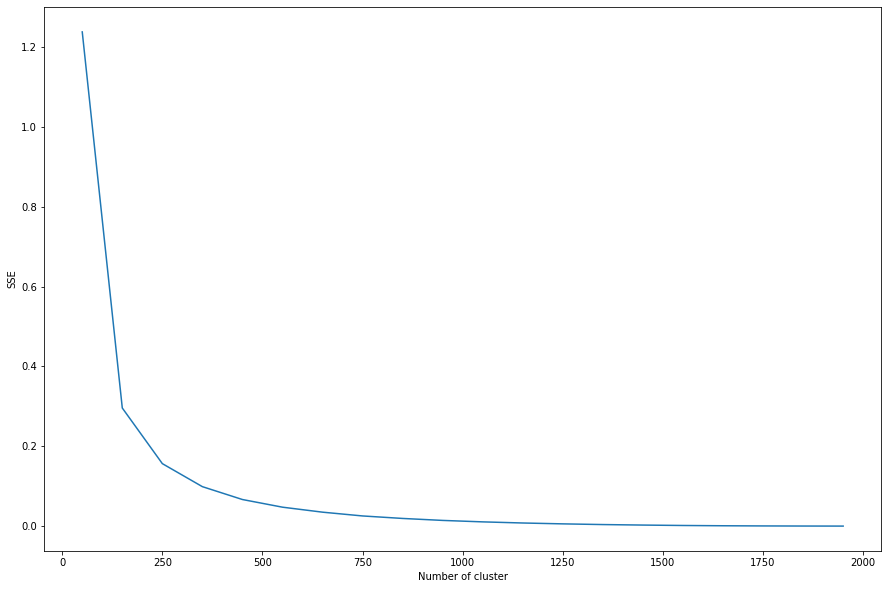

In [42]:
plt.figure(figsize=(15,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

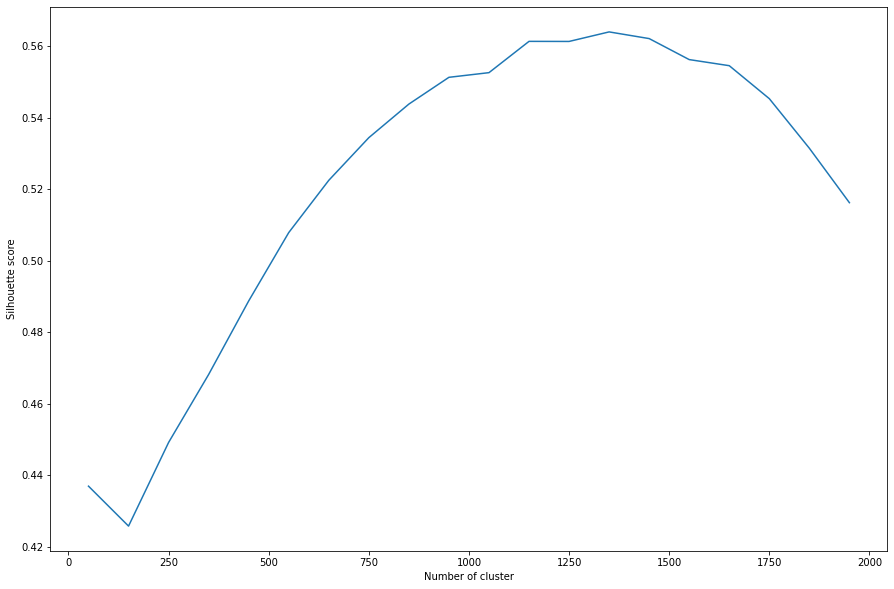

In [45]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

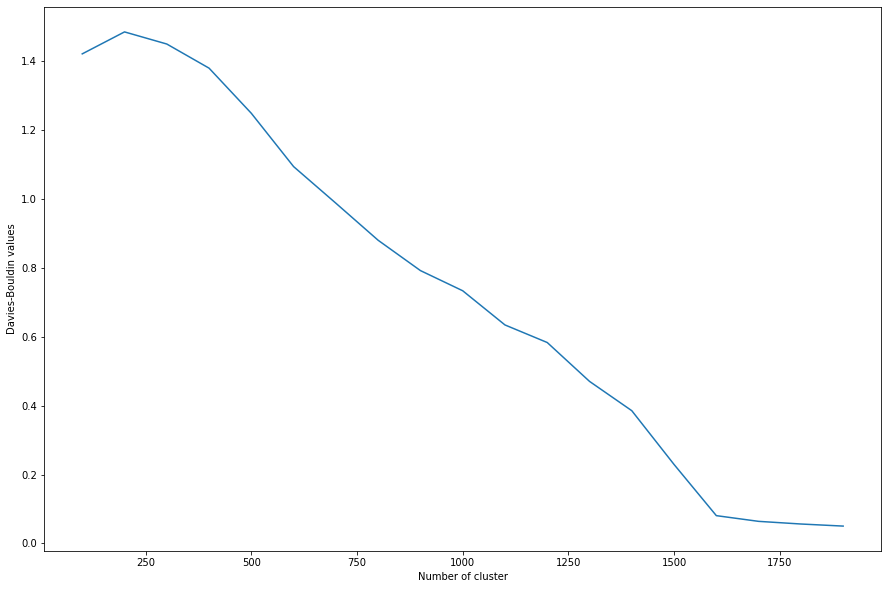

In [48]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

In [ ]:
# Decoder
# encoded_input = Input(shape=(16,))
# decoder_output = autoencoder.layers[-1]
# decoder = Model(encoded_input, decoder_output(encoded_input))

# # Use the decoder to reconstruct the original data
# X_decoded = decoder.predict(X_encoded)

<AxesSubplot:>

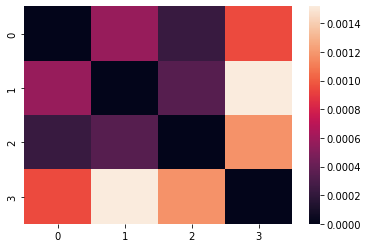

In [50]:
distances = []
for i in range(4):
    for j in range(i+1, 4):
        distance = np.linalg.norm(X_encoded[y_pred==i].mean() - X_encoded[y_pred==j].mean())
        distances.append((i, j, distance))

# Create a distance matrix
distance_matrix = np.zeros((4, 4))
for i, j, d in distances:
    distance_matrix[i, j] = d
    distance_matrix[j, i] = d

# Create a heatmap
sns.heatmap(distance_matrix)

<AxesSubplot:xlabel='cluster1', ylabel='distance'>

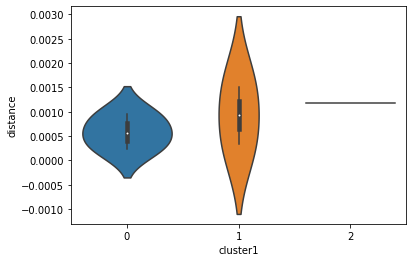

In [56]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

# Calculate the interclass distances
distances = []
for i in range(4):
    for j in range(i+1, 4):
        distance = np.linalg.norm(X_encoded[y_pred==i].mean() - X_encoded[y_pred==j].mean())
        distances.append((i, j, distance))

# Create a dataframe with the distances
df = pd.DataFrame(distances, columns=['cluster1', 'cluster2', 'distance'])

# Create a violin plot
sns.violinplot(x='cluster1', y='distance', data=df)